In [341]:
import torch
import torch.nn as nn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [342]:
### loading the data

train_df = pd.read_csv('../data/titanic/train.csv')
test_df = pd.read_csv('../data/titanic/test.csv')

train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [343]:
train_df.shape

(891, 12)

In [344]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [345]:
### Feature Age: Checking the mising values 

print("Missing Age values: ",train_df['Age'].isnull().sum())

average_age = train_df['Age'].mean()

print("Average Age on the existing passengers :",average_age)

### filling the missing age values with average age.

train_df['Age'] = train_df['Age'].fillna(average_age)

Missing Age values:  177
Average Age on the existing passengers : 29.69911764705882


In [346]:
train_df['Age'].isnull().value_counts()

False    891
Name: Age, dtype: int64

In [347]:
### Feature: Embarked
print(train_df['Embarked'].value_counts())

print("Missing Values: ", train_df['Embarked'].isnull().sum())

train_df['Embarked'] = train_df['Embarked'].fillna("Q")

print(train_df['Embarked'].value_counts())

S    644
C    168
Q     77
Name: Embarked, dtype: int64
Missing Values:  2
S    644
C    168
Q     79
Name: Embarked, dtype: int64


In [348]:
## Feature: PClass

train_df['Pclass'].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [349]:
### Feature: Sex

print(train_df['Sex'].value_counts())

male      577
female    314
Name: Sex, dtype: int64


In [350]:
### Feature Engineering
### Getting the Family Size

train_df['family_size'] = train_df['SibSp'] + train_df['Parch'] + 1
train_df['is_alone'] = np.where(train_df['family_size'] <= 1, 1, 0)

train_df['Sex_cat'] = train_df['Sex'].map({'male':0, 'female':1}) ## categorical value for sex
train_df['Embarked_cat'] = train_df['Embarked'].map({'S':1,'C':2,'Q':3}) ## categorical value for Embarked

train_df['is_kid'] = np.where(train_df['Age'] <= 18, 1, 0)

to_drop_cols = ['Sex','Embarked','Cabin','Ticket','Parch','SibSp','Name','Fare']

for cols in to_drop_cols:
    print("Dropping ",cols)
    train_df.drop(cols, axis=1, inplace=True)

train_df.head()

Dropping  Sex
Dropping  Embarked
Dropping  Cabin
Dropping  Ticket
Dropping  Parch
Dropping  SibSp
Dropping  Name
Dropping  Fare


,PassengerId,Survived,Pclass,Age,family_size,is_alone,Sex_cat,Embarked_cat,is_kid
0,1,0,3,22.0,2,0,0,1,0
1,2,1,1,38.0,2,0,1,2,0
2,3,1,3,26.0,1,1,1,1,0
3,4,1,1,35.0,2,0,1,1,0
4,5,0,3,35.0,1,1,0,1,0


In [351]:
train_df.dtypes

PassengerId       int64
Survived          int64
Pclass            int64
Age             float64
family_size       int64
is_alone          int64
Sex_cat           int64
Embarked_cat      int64
is_kid            int64
dtype: object

In [352]:
### selective feature: Sex, Pclass, Embarked, Age

X = train_df[['Pclass','Age','family_size','is_alone','Sex_cat','Embarked_cat','is_kid']]
y = train_df['Survived']

X.head()

,Pclass,Age,family_size,is_alone,Sex_cat,Embarked_cat,is_kid
0,3,22.0,2,0,0,1,0
1,1,38.0,2,0,1,2,0
2,3,26.0,1,1,1,1,0
3,1,35.0,2,0,1,1,0
4,3,35.0,1,1,0,1,0


In [353]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=33)

X_train.shape

(712, 7)

In [354]:
X_train = torch.FloatTensor(X_train.values)
y_train = torch.LongTensor(y_train.values)
X_test = torch.FloatTensor(X_test.values)
y_test = torch.LongTensor(y_test.values)

X_train

tensor([[ 3., 34.,  1.,  ...,  0.,  1.,  0.],
        [ 2., 40.,  3.,  ...,  1.,  1.,  0.],
        [ 3., 19.,  1.,  ...,  0.,  1.,  0.],
        ...,
        [ 2., 25.,  2.,  ...,  0.,  1.,  0.],
        [ 3., 21.,  1.,  ...,  0.,  1.,  0.],
        [ 2., 35.,  1.,  ...,  0.,  1.,  0.]])

In [355]:
## define the model

class Model(nn.Module):
    
    def __init__(self, num_features=7, h1=100, h2=50, out_features=2):
        super().__init__()
        
        self.input = nn.Linear(num_features,h1)
        self.h1_layer = nn.Linear(h1,h2)
        self.out = nn.Linear(h2, out_features)
        
    def forward(self, x):
        
        x = nn.functional.relu(self.input(x))
        x = nn.functional.relu(self.h1_layer(x))
        x = nn.functional.relu(self.out(x))
        
        return x

In [356]:
model = Model()

In [357]:
model

Model(
  (input): Linear(in_features=7, out_features=100, bias=True)
  (h1_layer): Linear(in_features=100, out_features=50, bias=True)
  (out): Linear(in_features=50, out_features=2, bias=True)
)

In [358]:
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [359]:
from torch.utils.data import DataLoader, Dataset

trainloader = DataLoader(X_train, batch_size=50, shuffle=True)
testloader = DataLoader(X_test, batch_size=50, shuffle=False)

In [360]:
epochs = 200
losses = []

for i in range(epochs):
    i+=1
    
    y_predict = model.forward(X_train)
    loss = criterion(y_predict, y_train)
    
    losses.append(loss)
    
    if i%10 == 0: 
        print(f'Epoch: {i} \t Loss: {loss}')
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Epoch: 10 	 Loss: 0.6880536675453186
Epoch: 20 	 Loss: 0.6815956830978394
Epoch: 30 	 Loss: 0.6775314807891846
Epoch: 40 	 Loss: 0.6694529056549072
Epoch: 50 	 Loss: 0.6832420825958252
Epoch: 60 	 Loss: 0.6822521090507507
Epoch: 70 	 Loss: 0.6805632710456848
Epoch: 80 	 Loss: 0.675341010093689
Epoch: 90 	 Loss: 0.6703391075134277
Epoch: 100 	 Loss: 0.6670693755149841
Epoch: 110 	 Loss: 0.6589434146881104
Epoch: 120 	 Loss: 0.6840556263923645
Epoch: 130 	 Loss: 0.6820749640464783
Epoch: 140 	 Loss: 0.6806818246841431
Epoch: 150 	 Loss: 0.6805750131607056
Epoch: 160 	 Loss: 0.6805224418640137
Epoch: 170 	 Loss: 0.6805676817893982
Epoch: 180 	 Loss: 0.6805197596549988
Epoch: 190 	 Loss: 0.6799463629722595
Epoch: 200 	 Loss: 0.6815553903579712


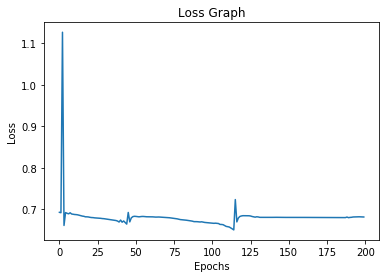

In [361]:
### plotting the losses

plt.plot(range(epochs), losses)
plt.title("Loss Graph")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()